In [1]:
import numpy as np

In [18]:
xs = np.loadtxt("../old_faithful.txt")
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

In [19]:
K = len(phis)
N = len(xs)
MAX_INTERS = 100
THESHOLD = 1e-4

In [20]:
def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov)
    return y

def likehood(xs, phis, mus, covs):
    eps = 1e-8
    L = 0
    N = len(xs)
    for x in xs:
        y = gmm(x, phis, mus, covs)
        L += np.log(y + eps)
    return L / N

In [23]:
phis = np.array([0.5, 0.5])
mus = np.array([[0.0, 50.0], [0.0, 100.0]])
covs = np.array([np.eye(2), np.eye(2)])

current_likelihood = likehood(xs, phis, mus, covs)
for iter in range(MAX_INTERS):
    # E-step
    qs = np.zeros((N, K))
    for n in range(N):
        x = xs[n]
        for k in range(K):
            phi, mu, cov = phis[k], mus[k], covs[k]
            qs[n, k] = phi * multivariate_normal(x, mu, cov)
        qs[n] = qs[n] / gmm(x, phis, mus, covs)
        
    # M-step
    qs_sum = qs.sum(axis=0)
    for k in range(K):
        # 1. phis
        phis[k] = qs_sum[k] / N
        
        # 2. mus
        c = 0
        for n in range(N):
            c += qs[n, k] * xs[n]
        mus[k] = c / qs_sum[k]
        
        # 3. covs
        c = 0
        for n in range(N):
            z = xs[n] - mus[k]
            z = z[:, np.newaxis]
            c += qs[n, k] * z @ z.T
        covs[k] = c / qs_sum[k]
        
    # 終了判定
    new_likelihood = likehood(xs, phis, mus, covs)
    print(new_likelihood)
    diff = np.abs(new_likelihood - current_likelihood)
    if diff < THESHOLD:
        break
    current_likelihood = new_likelihood

-4.415487912859895
-4.356967088689442
-4.302349361116248
-4.24531994276775
-4.2000967786544425
-4.164166440282439
-4.155724294329257
-4.155395069339015
-4.1553813134623026


In [24]:
N = 500
new_xs = np.zeros((N, 2))
for n in range(N):
    k = np.random.choice(2, p=phis)
    mu, cov = mus[k], covs[k]
    new_xs[n] = np.random.multivariate_normal(mu, cov)

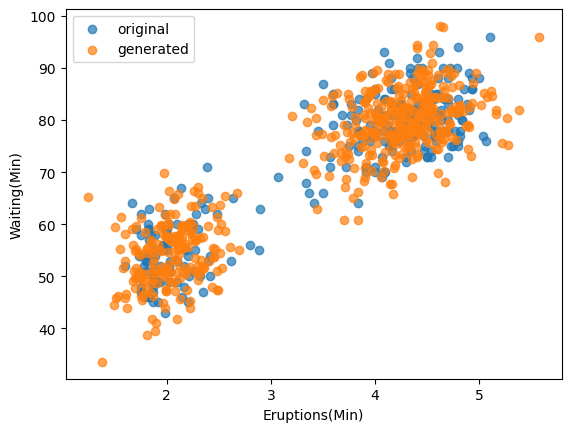

In [26]:
import matplotlib.pyplot as plt
original_xs = np.loadtxt("../old_faithful.txt")
plt.scatter(original_xs[:,0], original_xs[:,1], alpha=0.7, label='original')
plt.scatter(new_xs[:,0], new_xs[:,1], alpha=0.7, label='generated')
plt.legend()
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()